In [1]:
pip install -q phik 

Note: you may need to restart the kernel to use updated packages.


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import phik


RANDOM_STATE = 42

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)


Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

Цель- Предсказать вероятность покупки в течение 90 дней
Задачи
●
Изучить данные
●
Разработать полезные признаки
●
Создать модель для классификации пользователей
●
Улучшить модель и максимизировать метрику roc_auc
●
Выполнить тестирование
Данные
apparel-purchases
история покупок
●
client_id идентификатор пользователя
●
quantity количество товаров в заказе
●
price цена товара
●
category_ids вложенные категории, к которым отнсится товар
●
date дата покупки
●
message_id идентификатор сообщения из рассылки
apparel-messages
история рекламных рассылок
●
bulk_campaign_id идентификатор рекламной кампании
●
client_id идентификатор пользователя
●
message_id идентификатор сообщений
●
event тип действия
●
channel канал рассылки
●
date дата рассылки
●
created_at точное время создания сообщения

Загрузим все датасеты и посмотрим их содержимое

In [3]:
purchases = pd.read_csv('apparel-purchases.csv')
display(purchases.head())
display(purchases.info())
display(purchases.isna().sum())

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


None

client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

Пропусков нет, скорректируем тип данных в столбце date

In [4]:
purchases['date'] = pd.to_datetime(purchases['date'])

In [5]:
messages = pd.read_csv('apparel-messages.csv')
display(messages.head())
display(messages.info())
display(messages.isna().sum())

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


None

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

Пропусков в данных нет, необходимо изменить тип данных в столбцах date и created_at

In [6]:
messages['date'] = pd.to_datetime(messages['date'])
messages['created_at'] = pd.to_datetime(messages['created_at'])

In [7]:
target_binary = pd.read_csv('apparel-target_binary.csv')
display(target_binary.head())
display(target_binary.info())
display(target_binary.isna().sum())

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None

client_id    0
target       0
dtype: int64

Пропусков нет, типы данных корректные.

In [8]:
full_campaign_daily_event = pd.read_csv('full_campaign_daily_event.csv')
display(full_campaign_daily_event.head())
display(full_campaign_daily_event.info())
display(full_campaign_daily_event.isna().sum())

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

None

date                   0
bulk_campaign_id       0
count_click            0
count_complain         0
count_hard_bounce      0
count_open             0
count_purchase         0
count_send             0
count_soft_bounce      0
count_subscribe        0
count_unsubscribe      0
nunique_click          0
nunique_complain       0
nunique_hard_bounce    0
nunique_open           0
nunique_purchase       0
nunique_send           0
nunique_soft_bounce    0
nunique_subscribe      0
nunique_unsubscribe    0
count_hbq_spam         0
nunique_hbq_spam       0
count_close            0
nunique_close          0
dtype: int64

Пропусков в данных нет, необходимо изменить тип данных в столбце date

In [9]:
full_campaign_daily_event['date'] = pd.to_datetime(full_campaign_daily_event['date'])

In [10]:
full_campaign_daily_event_channel = pd.read_csv('full_campaign_daily_event_channel.csv')
display(full_campaign_daily_event_channel.head())
display(full_campaign_daily_event_channel.info())
display(full_campaign_daily_event_channel.isna().sum())

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

None

date                               0
bulk_campaign_id                   0
count_click_email                  0
count_click_mobile_push            0
count_open_email                   0
count_open_mobile_push             0
count_purchase_email               0
count_purchase_mobile_push         0
count_soft_bounce_email            0
count_subscribe_email              0
count_unsubscribe_email            0
nunique_click_email                0
nunique_click_mobile_push          0
nunique_open_email                 0
nunique_open_mobile_push           0
nunique_purchase_email             0
nunique_purchase_mobile_push       0
nunique_soft_bounce_email          0
nunique_subscribe_email            0
nunique_unsubscribe_email          0
count_hard_bounce_mobile_push      0
count_send_mobile_push             0
nunique_hard_bounce_mobile_push    0
nunique_send_mobile_push           0
count_hard_bounce_email            0
count_hbq_spam_email               0
count_send_email                   0
n

Пропусков в данных нет, необходимо изменить тип данных в столбце date

In [11]:
full_campaign_daily_event_channel['date'] = pd.to_datetime(full_campaign_daily_event_channel['date'])

Проверим наличие явных дубликатов в датасетах

In [12]:
purchases.duplicated().sum()

73020

In [13]:
messages.duplicated().sum()

48610

In [14]:
target_binary.duplicated().sum()

0

In [15]:
full_campaign_daily_event.duplicated().sum()

0

In [16]:
full_campaign_daily_event_channel.duplicated().sum()

0

Видим наличие дубликатов в первых двух датасетах. Перед объединением датасета для дальнейшего анализа - удалим дубликаты (не смотря на их количество)

In [17]:
purchases = purchases.drop_duplicates()

In [18]:
messages = messages.drop_duplicates()

Дубликаты удалили - приступим к дальнейшему преобразованию датасетов и поиску неявных дубликатов. 

Для начала узнаем сколько максиимально категорий содержится в каждом списке в столбце category_ids

In [19]:
# Преобразуем строковые значения списков в объекты списка и находим максимальную длину
max_categories = purchases['category_ids'].apply(lambda x: len(eval(x)) if isinstance(x, str) else len(x)).max()

print("Максимальное количество категорий в списке:", max_categories)

Максимальное количество категорий в списке: 5


разобьем значения столбца 'category_ids' на 5 столбцов , для дальнейшего анализа

In [20]:
purchases[['category_id_1', 'category_id_2', 'category_id_3', 'category_id_4', 'category_id_5']] = (
    purchases['category_ids']
    .apply(lambda x: eval(x) if isinstance(x, str) else x)  # Преобразуем строку в список, если это строка
    .apply(lambda x: x[:5] + [0] * (5 - len(x)) if len(x) < 5 else x[:5])  # Ограничиваем список до 5 элементов
    .apply(pd.Series)  # Разделяем список на отдельные столбцы
)


In [21]:
purchases[['category_id_1', 'category_id_2', 'category_id_3', 'category_id_4', 'category_id_5']].head()

,category_id_1,category_id_2,category_id_3,category_id_4,category_id_5
0,4,28,57,431,0
1,4,28,57,431,0
2,4,28,57,431,0
3,4,28,244,432,0
4,4,28,49,413,0


Посомтрим сколько пропусков в стобце category_id_5

In [22]:
zero_values = (purchases['category_id_5'] == 0).sum()
print("Количество значений '0' в столбце category_id_5:", zero_values)

Количество значений '0' в столбце category_id_5: 128843


Проверим есть ли в созданных столбцах пропуски:

In [23]:
purchases[['category_id_1', 'category_id_2', 'category_id_3', 'category_id_4', 'category_id_5']].isna().sum()

category_id_1    622
category_id_2      0
category_id_3      0
category_id_4      0
category_id_5      0
dtype: int64

Заменим выявленные пропуски в столбце category_id_1  на 0

In [24]:
purchases['category_id_1'] = purchases['category_id_1'].fillna('0')

Посомтрим информацию по датасету

In [25]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129188 entries, 0 to 202207
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   client_id      129188 non-null  int64         
 1   quantity       129188 non-null  int64         
 2   price          129188 non-null  float64       
 3   category_ids   129188 non-null  object        
 4   date           129188 non-null  datetime64[ns]
 5   message_id     129188 non-null  object        
 6   category_id_1  129188 non-null  object        
 7   category_id_2  129188 non-null  object        
 8   category_id_3  129188 non-null  object        
 9   category_id_4  129188 non-null  object        
 10  category_id_5  129188 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 11.8+ MB


Переведем значения созданных столбцов из типа object в тип int64

In [26]:
purchases[['category_id_1', 'category_id_2', 'category_id_3', 'category_id_4', 'category_id_5']] = purchases[['category_id_1', 'category_id_2', 'category_id_3', 'category_id_4', 'category_id_5']].astype('int')

Посмотрим на распределение значений датасетов

In [27]:
purchases.describe()

,client_id,quantity,price,category_id_1,category_id_2,category_id_3,category_id_4,category_id_5
count,1.291880e+05,129188.000000,129188.000000,129188.000000,129188.000000,129188.000000,129188.000000,129188.000000
mean,1.515916e+18,1.009420,1264.532766,1503.012594,1590.442727,1737.924993,875.127427,1.247136
std,1.452553e+08,0.220332,1375.016339,2491.047010,2505.832499,2446.268124,1041.499742,24.101071
min,1.515916e+18,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.515916e+18,1.000000,399.000000,4.000000,28.000000,171.000000,432.000000,0.000000
50%,1.515916e+18,1.000000,999.000000,4.000000,28.000000,274.000000,551.000000,0.000000
75%,1.515916e+18,1.000000,1750.000000,5562.000000,5536.000000,5549.000000,726.000000,0.000000
max,1.515916e+18,30.000000,85499.000000,6060.000000,6059.000000,6309.000000,6323.000000,467.000000


In [28]:
messages.describe()

,bulk_campaign_id,client_id
count,1.269119e+07,1.269119e+07
mean,1.159768e+04,1.515916e+18
std,3.262181e+03,1.329008e+08
min,5.480000e+02,1.515916e+18
25%,8.746000e+03,1.515916e+18
50%,1.351600e+04,1.515916e+18
75%,1.415800e+04,1.515916e+18
max,1.465700e+04,1.515916e+18


In [29]:
target_binary.describe()

,client_id,target
count,4.984900e+04,49849.000000
mean,1.515916e+18,0.019278
std,1.487947e+08,0.137503
min,1.515916e+18,0.000000
25%,1.515916e+18,0.000000
50%,1.515916e+18,0.000000
75%,1.515916e+18,0.000000
max,1.515916e+18,1.000000


In [30]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129188 entries, 0 to 202207
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   client_id      129188 non-null  int64         
 1   quantity       129188 non-null  int64         
 2   price          129188 non-null  float64       
 3   category_ids   129188 non-null  object        
 4   date           129188 non-null  datetime64[ns]
 5   message_id     129188 non-null  object        
 6   category_id_1  129188 non-null  int64         
 7   category_id_2  129188 non-null  int64         
 8   category_id_3  129188 non-null  int64         
 9   category_id_4  129188 non-null  int64         
 10  category_id_5  129188 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(2)
memory usage: 11.8+ MB


In [31]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12691188 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 774.6+ MB


In [32]:
target_binary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


В датасет purchases добавим столбец purchase_frequency, который показывает количество покупок, совершенных каждым client_id. Теперь каждое значение в этом столбце отображает, сколько раз данный client_id встречается в датасете. 

In [33]:
purchase_frequency = purchases['client_id'].value_counts().to_dict()
purchases['purchase_frequency'] = purchases['client_id'].map(purchase_frequency)

purchases

,client_id,quantity,price,category_ids,date,message_id,category_id_1,category_id_2,category_id_3,category_id_4,category_id_5,purchase_frequency
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,0,8
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,0,8
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,57,431,0,3
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,244,432,0,3
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,49,413,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
202196,1515915626010221592,1,1499.0,"['4', '28', '260', '1194']",2024-02-16,1515915626010221592-14664-65cf1622434a9,4,28,260,1194,0,1
202198,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,2,18,212,726,0,1
202204,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,4,27,233,462,0,1
202206,1515915626010443527,1,1999.0,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490,2,18,274,446,0,1


Так как ключевой идентификатор во всех датасетах у меня client_id - для объединения датасета будем использовать  метод pd.merge() с how='inner'. Этот метод объединит только те записи, которые имеют совпадающие client_id во всех трех таблицах. Пере этим, чтобы избежать конфликта переименуем в датасете messages название столбца date на date_messages 

In [34]:
messages.rename(columns={'date': 'date_messages'}, inplace=True)

Также проверим сколько уникальных значений client_id в кажом датасете

In [35]:
unique_target_binary = target_binary['client_id'].nunique()
unique_purchases = purchases['client_id'].nunique()
unique_messages = messages['client_id'].nunique()

display(f"Уникальные client_id в target_binary: {unique_target_binary}")
display(f"Уникальные client_id в purchases: {unique_purchases}")
display(f"Уникальные client_id в messages: {unique_messages}")

'Уникальные client_id в target_binary: 49849'

'Уникальные client_id в purchases: 49849'

'Уникальные client_id в messages: 53329'

В датасетах purchases и  messages проведем группировку по client_id с выбором наиболее часто встречающегося значения в каждом столбце

In [36]:
purchases_group = purchases.groupby('client_id').agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])

# Сбрасываем индекс, чтобы вернуть client_id как столбец, а не индекс
purchases_group = purchases_group.reset_index()

In [37]:
messages_group = messages.groupby('client_id').agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
messages_group = messages_group.reset_index()

In [38]:
purchases_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   client_id           49849 non-null  int64         
 1   quantity            49849 non-null  int64         
 2   price               49849 non-null  float64       
 3   category_ids        49849 non-null  object        
 4   date                49849 non-null  datetime64[ns]
 5   message_id          49849 non-null  object        
 6   category_id_1       49849 non-null  int64         
 7   category_id_2       49849 non-null  int64         
 8   category_id_3       49849 non-null  int64         
 9   category_id_4       49849 non-null  int64         
 10  category_id_5       49849 non-null  int64         
 11  purchase_frequency  49849 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(8), object(2)
memory usage: 4.6+ MB


In [39]:
messages_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53329 entries, 0 to 53328
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   client_id         53329 non-null  int64         
 1   bulk_campaign_id  53329 non-null  int64         
 2   message_id        53329 non-null  object        
 3   event             53329 non-null  object        
 4   channel           53329 non-null  object        
 5   date_messages     53329 non-null  datetime64[ns]
 6   created_at        53329 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 2.8+ MB


In [40]:
#Объединяем purchases и target_binary по client_id с внутренним соединением
merged_df = pd.merge(target_binary, purchases_group, on='client_id', how='inner')

In [41]:
# Затем объединяем результат с messages
merged_df = pd.merge(merged_df, messages_group, on='client_id', how='inner')


In [42]:
# Убедимся, что все client_id заполнены
display(merged_df.head())
display(merged_df.info())

,client_id,target,quantity,price,category_ids,date,message_id_x,category_id_1,category_id_2,category_id_3,category_id_4,category_id_5,purchase_frequency,bulk_campaign_id,message_id_y,event,channel,date_messages,created_at
0,1515915625468060902,0,1,199.0,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,4,28,176,420,0,5,4617,1515915625468060902-4617-6290657dac196,send,email,2022-05-27,2022-05-19 06:32:28
1,1515915625468061003,1,1,1749.0,"['4', '28', '249', '615']",2023-01-04,1515915625468061003-9148-63b54b04855a4,4,28,249,615,0,6,9148,1515915625468061003-12566-646330138e845,send,email,2023-01-04,2023-01-04 17:17:07
2,1515915625468061099,0,1,299.0,"['4', '28', '290', '424']",2022-05-17,1515915625468061099-4439-62834141aa538,4,28,290,424,0,1,9945,1515915625468061099-9945-63e34e9af27f3,send,email,2022-08-19,2022-09-22 13:30:14
3,1515915625468061100,0,1,1049.0,"['4', '27', '1828', '5717']",2024-02-10,1515915625468061100-14623-65c5c55eeb9e0,4,27,1828,5717,0,1,14280,1515915625468061100-14623-65c5c55eeb9e0,send,mobile_push,2023-05-18,2022-12-26 13:49:05
4,1515915625468061170,0,1,7.0,"['4', '28', '260', '420']",2023-03-29,1515915625468061170-11208-6423f082d2fcb,4,28,260,420,0,8,11144,1515915625468061170-11144-641ad2cda77a2,send,email,2022-09-16,2023-03-25 02:05:43


<class 'pandas.core.frame.DataFrame'>
Int64Index: 41982 entries, 0 to 41981
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   client_id           41982 non-null  int64         
 1   target              41982 non-null  int64         
 2   quantity            41982 non-null  int64         
 3   price               41982 non-null  float64       
 4   category_ids        41982 non-null  object        
 5   date                41982 non-null  datetime64[ns]
 6   message_id_x        41982 non-null  object        
 7   category_id_1       41982 non-null  int64         
 8   category_id_2       41982 non-null  int64         
 9   category_id_3       41982 non-null  int64         
 10  category_id_4       41982 non-null  int64         
 11  category_id_5       41982 non-null  int64         
 12  purchase_frequency  41982 non-null  int64         
 13  bulk_campaign_id    41982 non-null  int64     

None

Дополним датасет новыми признаками. Дополним месяцев и годом из столбца date

In [43]:
merged_df['year'] = merged_df['date'].dt.year
merged_df['month'] = merged_df['date'].dt.month

In [44]:
#сумма за покупку в категории
merged_df['revenue'] = merged_df['quantity'] * merged_df['price']

Создадим признак last_purchase_date и first_purchase_date, в котором будут данные с количеством прошедших дней от последней покупи. Для этого вычтем дату выгрузки таблицы из date. Столбец first_purchase_date аналогичен last_purchase_date, он нам понадобится в дальнейшем для агригации.

In [45]:
merged_df['date'].max()

Timestamp('2024-02-16 00:00:00')

In [46]:
merged_df['last_date'] = (pd.to_datetime('2024-02-16') - merged_df['date']).dt.days

логарифмируем столбец price, создавая новый столбец и новый признак соответственно

In [47]:
# Логарифмирование столбца (используя np.log1p для обработки значений 0 корректно) 
merged_df['price_log'] = np.log1p(merged_df['price']) 
# Вывод первых строк для проверки 
display(merged_df.head())

,client_id,target,quantity,price,category_ids,date,message_id_x,category_id_1,category_id_2,category_id_3,...,message_id_y,event,channel,date_messages,created_at,year,month,revenue,last_date,price_log
0,1515915625468060902,0,1,199.0,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,4,28,176,...,1515915625468060902-4617-6290657dac196,send,email,2022-05-27,2022-05-19 06:32:28,2022,5,199.0,630,5.298317
1,1515915625468061003,1,1,1749.0,"['4', '28', '249', '615']",2023-01-04,1515915625468061003-9148-63b54b04855a4,4,28,249,...,1515915625468061003-12566-646330138e845,send,email,2023-01-04,2023-01-04 17:17:07,2023,1,1749.0,408,7.467371
2,1515915625468061099,0,1,299.0,"['4', '28', '290', '424']",2022-05-17,1515915625468061099-4439-62834141aa538,4,28,290,...,1515915625468061099-9945-63e34e9af27f3,send,email,2022-08-19,2022-09-22 13:30:14,2022,5,299.0,640,5.703782
3,1515915625468061100,0,1,1049.0,"['4', '27', '1828', '5717']",2024-02-10,1515915625468061100-14623-65c5c55eeb9e0,4,27,1828,...,1515915625468061100-14623-65c5c55eeb9e0,send,mobile_push,2023-05-18,2022-12-26 13:49:05,2024,2,1049.0,6,6.956545
4,1515915625468061170,0,1,7.0,"['4', '28', '260', '420']",2023-03-29,1515915625468061170-11208-6423f082d2fcb,4,28,260,...,1515915625468061170-11144-641ad2cda77a2,send,email,2022-09-16,2023-03-25 02:05:43,2023,3,7.0,324,2.079442


Удалим лишние столбцы в датасете

In [48]:
merged_df = merged_df.drop(columns=['client_id','category_ids', 'date', 'message_id_x', 'message_id_y', 'date_messages', 'created_at'])

# Выводим результат, чтобы убедиться, что столбцы удалены
merged_df.head()

,target,quantity,price,category_id_1,category_id_2,category_id_3,category_id_4,category_id_5,purchase_frequency,bulk_campaign_id,event,channel,year,month,revenue,last_date,price_log
0,0,1,199.0,4,28,176,420,0,5,4617,send,email,2022,5,199.0,630,5.298317
1,1,1,1749.0,4,28,249,615,0,6,9148,send,email,2023,1,1749.0,408,7.467371
2,0,1,299.0,4,28,290,424,0,1,9945,send,email,2022,5,299.0,640,5.703782
3,0,1,1049.0,4,27,1828,5717,0,1,14280,send,mobile_push,2024,2,1049.0,6,6.956545
4,0,1,7.0,4,28,260,420,0,8,11144,send,email,2023,3,7.0,324,2.079442


<AxesSubplot:ylabel='target'>

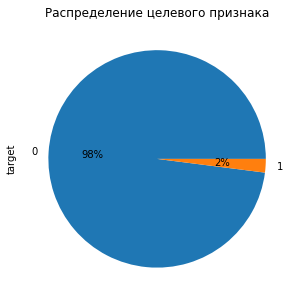

In [49]:
# Посмотрим на распределение целевого признака:
display(merged_df['target'].value_counts().plot(y='count', kind='pie', figsize=(5, 5), autopct='%.0f%%'))
plt.title('Распределение целевого признака')
plt.show();

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable bulk_campaign_id is large: 1249. Are you sure this is not an interval variable? Analysis for pairs of variables including bulk_campaign_id can be slow.
  warnings.warn(


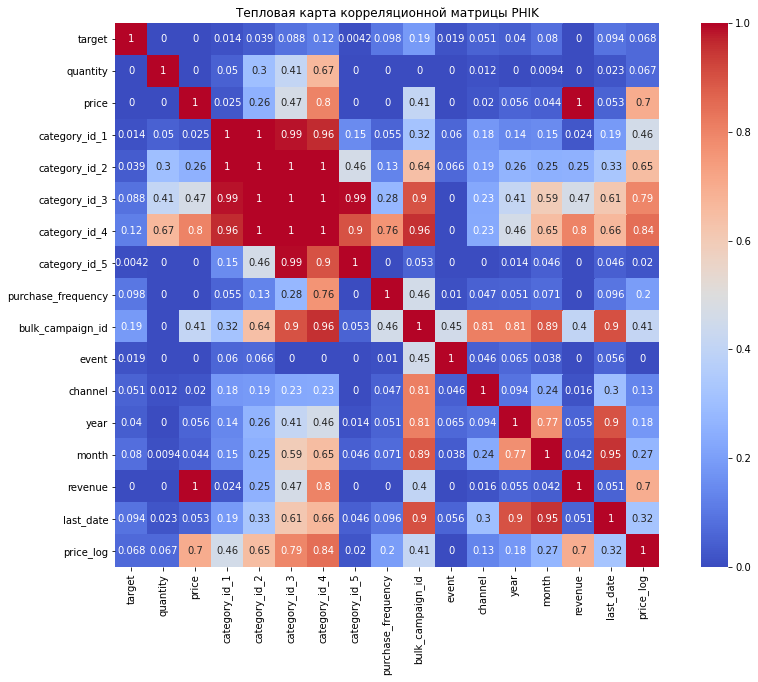

In [50]:
# Расчет корреляционной матрицы PHIK 
phik_matrix = merged_df.phik_matrix(interval_cols=['quantity', 'price', 'price_log','year', 'month','last_date', 'revenue', 'purchase_frequency'])
# Построение тепловой карты 
plt.figure(figsize=(15, 10)) 
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', square=True) 
plt.title('Тепловая карта корреляционной матрицы PHIK') 
plt.show()

Корреляция между purchase_frequency и target:

purchase_frequency имеет небольшую положительную корреляцию с target (PHIK ≈ 0.1). Это говорит о том, что клиенты с более высокой частотой покупок немного чаще достигают целевого события. Таким образом, purchase_frequency можно считать полезным признаком для модели.
Корреляция с другими переменными:

purchase_frequency также имеет заметную корреляцию с некоторыми признаками категорий (например, category_id_1, category_id_3), что указывает на определенную связь между частотой покупок и принадлежностью клиента к определенным категориям товаров.
Наблюдается небольшая корреляция purchase_frequency с price и price_log, что может свидетельствовать о том, что клиенты с более высокой частотой покупок склонны покупать товары с определенной ценовой категорией.
Прочие признаки и target:

Как и в предыдущем анализе, признаки bulk_campaign_id, price, и category_id_4 остаются значимыми, поскольку они показывают слабую или умеренную корреляцию с target.
Корреляции между target и признаками времени (year, month) по-прежнему остаются низкими, что указывает на слабую зависимость целевой переменной от сезонности.
Рекомендации:

purchase_frequency может быть полезен для модели, так как он добавляет дополнительную информацию о поведении клиентов.
Можно также рассмотреть создание дополнительных признаков, связанных с взаимодействием клиента с разными категориями, либо показатели их активности на временной шкале для дальнейшего улучшения предсказательной силы модели.

выделим целевую переменную и разделим выборку на тренировочную и тестовую

In [51]:
features = merged_df.drop(['target'], axis=1)
target = merged_df['target']

features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size = 0.25, 
    random_state = RANDOM_STATE)

проведем масштабирование колличественных признаков и кодирование категориальных

In [52]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41982 entries, 0 to 41981
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   target              41982 non-null  int64  
 1   quantity            41982 non-null  int64  
 2   price               41982 non-null  float64
 3   category_id_1       41982 non-null  int64  
 4   category_id_2       41982 non-null  int64  
 5   category_id_3       41982 non-null  int64  
 6   category_id_4       41982 non-null  int64  
 7   category_id_5       41982 non-null  int64  
 8   purchase_frequency  41982 non-null  int64  
 9   bulk_campaign_id    41982 non-null  int64  
 10  event               41982 non-null  object 
 11  channel             41982 non-null  object 
 12  year                41982 non-null  int64  
 13  month               41982 non-null  int64  
 14  revenue             41982 non-null  float64
 15  last_date           41982 non-null  int64  
 16  pric

In [53]:
# Определение категориальных и числовых признаков
ohe_columns = ['event', 'channel']
num_columns = ['quantity', 'price', 'purchase_frequency', 'year', 'month', 'revenue', 'last_date', 'price_log']

# Pipeline для числовых признаков
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Pipeline для категориальных признаков (One-Hot Encoding)
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
])

# Объединение числового и категориального пайплайнов с помощью ColumnTransformer
data_preprocessor = ColumnTransformer([
    ('num', num_pipe, num_columns),
    ('ohe', ohe_pipe, ohe_columns)
])

# Финальный пайплайн с моделью LogisticRegression
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LogisticRegression(max_iter=1000))  # Увеличиваем число итераций для сходимости
])

Обучим модель линейной регрессии

In [54]:
model_catboost = CatBoostClassifier(verbose=0)

# Определяем сетку гиперпараметров для поиска
param_grid_catboost = {
    'iterations': [100, 200], 
    'depth': [4, 6],
    'learning_rate': [0.01, 0.1],
    'l2_leaf_reg': [1, 3],
    'bagging_temperature': [0.2, 0.5],
    'border_count': [32, 64]
}

random_search_cv_catboost = RandomizedSearchCV(
    estimator=model_catboost, 
    param_distributions=param_grid_catboost,
    n_iter=5,
    cv=3, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1,
    refit=True
)

# Обучаем модель с подбором гиперпараметров
random_search_cv_catboost.fit(
    features_train, 
    target_train, 
    cat_features=ohe_columns
)

# Получаем лучшие гиперпараметры
best_params_catboost = random_search_cv_catboost.best_params_

# Получаем среднее время обучения и предсказания из cv_results_
mean_fit_time_catboost = random_search_cv_catboost.cv_results_['mean_fit_time'][random_search_cv_catboost.best_index_]
mean_score_time_catboost = random_search_cv_catboost.cv_results_['mean_score_time'][random_search_cv_catboost.best_index_]

# Получаем метрику ROC AUC на валидации
best_roc_auc_catboost = random_search_cv_catboost.best_score_

# Выводим результаты
print("Лучшие гиперпараметры для CatBoost: ", best_params_catboost)
print(f"Среднее время обучения: {mean_fit_time_catboost:.2f} секунд")
print(f"Среднее время предсказания: {mean_score_time_catboost:.2f} секунд")
print(f"Метрика roc_auc на валидации: {best_roc_auc_catboost:.2f}")


Лучшие гиперпараметры для CatBoost:  {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 200, 'depth': 4, 'border_count': 32, 'bagging_temperature': 0.2}
Среднее время обучения: 3.85 секунд
Среднее время предсказания: 0.01 секунд
Метрика roc_auc на валидации: 0.68


Преобразуем категориальные данные: event и channel можем преобразовать их в числовые представления.

In [55]:
le_event = LabelEncoder()
features_train['event'] = le_event.fit_transform(features_train['event'])

le_channel = LabelEncoder()
features_train['channel'] = le_channel.fit_transform(features_train['channel'])

/tmp/ipykernel_63/2374497055.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train['event'] = le_event.fit_transform(features_train['event'])
/tmp/ipykernel_63/2374497055.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train['channel'] = le_channel.fit_transform(features_train['channel'])


Попробуем другую модель

In [56]:
model_xgb = XGBClassifier(
    objective='binary:logistic',  # Задаем цель для бинарной классификации
    eval_metric='auc',             # Метрика для оценки
    verbosity=0,                   # Отключаем вывод логов
    use_label_encoder=False         # Отключаем использование LabelEncoder
)


# Определяем распределение гиперпараметров для поиска
param_distributions_xgb = {
    'n_estimators': [100, 200],    
    'max_depth': [3, 5, 7],       
    'learning_rate': [0.01, 0.1, 0.2], 
    'subsample': [0.6, 0.7, 0.8],  
    'colsample_bytree': [0.6, 0.7],  
    'reg_alpha': [0, 0.1, 1],       
    'reg_lambda': [1, 1.5, 2]       
}

# Заменяем GridSearchCV на RandomizedSearchCV
random_search_cv_xgb = RandomizedSearchCV(
    estimator=model_xgb, 
    param_distributions=param_distributions_xgb, 
    n_iter=10,  # Количество итераций для случайного поиска
    cv=3, 
    scoring='roc_auc',  # Используем метрику roc_auc для классификации
    n_jobs=-1,  
    random_state=RANDOM_STATE,  
    refit=True  
)

# Обучаем модель с подбором гиперпараметров
random_search_cv_xgb.fit(features_train, target_train)

# Получаем лучшие гиперпараметры
best_params_xgb = random_search_cv_xgb.best_params_

# Получаем среднее время обучения и предсказания из cv_results_
mean_fit_time_xgb = random_search_cv_xgb.cv_results_['mean_fit_time'][random_search_cv_xgb.best_index_]
mean_score_time_xgb = random_search_cv_xgb.cv_results_['mean_score_time'][random_search_cv_xgb.best_index_]

# Получаем метрику AUC на валидации
best_auc_xgb = random_search_cv_xgb.best_score_

# Выводим результаты
print(f"Лучшие гиперпараметры для XGBoost: {best_params_xgb}")
print(f"Среднее время обучения: {mean_fit_time_xgb:.2f} секунд")
print(f"Среднее время предсказания: {mean_score_time_xgb:.2f} секунд")
print(f"Метрика AUC на валидации: {best_auc_xgb:.2f}")

Лучшие гиперпараметры для XGBoost: {'subsample': 0.7, 'reg_lambda': 1.5, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Среднее время обучения: 11.55 секунд
Среднее время предсказания: 0.06 секунд
Метрика AUC на валидации: 0.69


Для построения прогноза на тестовых данных будем использовать модель CatBoostClassifier, так как она демонстрирует наилучший баланс между качеством предсказаний и временем обучения. Метрика на 0.01 ниже, чем у модели XGBoost - не существенно.

In [60]:
# Получаем лучшую модель после подбора гиперпараметров и делаем предсказания.
best_model_catboost = random_search_cv_catboost.best_estimator_
predictions_probabilities = best_model_catboost.predict_proba(features_test)[:, 1]

# Рассчитываем roc_auc на тестовой выборке
auc_catboost = roc_auc_score(target_test, predictions_probabilities)

auc_catboost

0.6804974641121735

# Вывод по проекту

В данном проекте была поставлена задача предсказать вероятность покупки товаров пользователями интернет-магазина в течение 90 дней. Для достижения этой цели была проведена комплексная работа, включающая изучение данных, разработку новых признаков, создание и оптимизацию моделей машинного обучения.

**Описание процесса**

* Изучение данных: На начальном этапе был проведен анализ доступных данных, что позволило лучше понять структуру и характеристики пользователей, а также выявить потенциальные закономерности.

* Разработка признаков: На основе анализа были созданы новые признаки, которые могут улучшить качество предсказаний. 

* Создание моделей: В рамках проекта были построены две модели классификации: CatBoost и XGBoost. Обе модели были настроены на максимизацию метрики ROC AUC, что позволяет оценить качество предсказаний в контексте бинарной классификации.

* Для финального прогноза на тестовых данных была выбрана модель CatBoostClassifier, так как она продемонстрировала наилучший баланс между качеством предсказаний и временем обучения. Несмотря на то, что метрика на тестовых данных (0.6805) оказалась на 0.01 ниже, чем у модели XGBoost, это различие является несущественным в контексте практического применения.

**Заключение**

В результате проведенной работы была достигнута поставленная цель — предсказание вероятности покупки пользователями интернет-магазина в течение 90 дней. Модель CatBoostClassifier, выбранная для финального прогноза, показала удовлетворительные результаты, что позволяет использовать её для дальнейших бизнес-процессов, таких как целевая рассылка предложений и планирование будущих продаж. Рекомендуется продолжать мониторинг и улучшение модели с учетом новых данных и изменений в поведении пользователей для повышения точности предсказаний.